# Text Summarization using T5 Model

## About the Model

The project aims to develop an effective text summarization algorithm for news articles using T5 architecture. T5 models are pre-trained on the Colossal Clean Crawled Corpus (C4), containing text and code scraped from the internet. This pre-training process made T5 capable of understanding the general language and being able to generate texts (Wikipedia). T5 can be fine-tuned based on needed tasks; however, adjusting the T5 model can be challenging and computationally expensive.


According to Huggingface, the T5 model was introduced in the article "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer" by Raffel et al. (2020). T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks, for which each task is converted into a text-to-text format. T5 comes in different sizes such as small, base, large, 3b, and 11b.
In this project, we used a base model. Unlike models such as BERT or GPT, which are made up of the encoder or decoder, T5 uses complete encoder-decoder architecture, which is better than only using the decoder (Muia, 2024).
According to Muia (2024), T5 outperforms other models regarding Rouge scores. T5 returns the highest scores for the four Rouge metrics. BART and PEGASUS come close to competing with T5, while The GPT model displays lower Rouge scores overall.
The project focuses on leveraging T5's capabilities in summarization tasks, evaluating its performance, and deploying it in practical applications for efficient information retrieval and content summarization.


![](https://production-media.paperswithcode.com/methods/new_text_to_text.jpg)

T5 utilizes transformer architecture, self-attention mechanisms, multi-head attention, positional encodings, feedforward neural networks (FFNNs), layer normalization, and residual connections. The training process involves optimizing parameters through backpropagation and gradient descent algorithms. Due to the nature of T5, the model requires a pair of input and output sequences/text for training or finetuning. There are some tasks we can do with T5 are: machine translation, classification task, regression task ( for instance, predict how similar two sentences are, the similarity score is in range 1 to 5), and other sequence to sequence tasks like document summarization.


Let's take a look at T5 model's upsides and downsides:

Upsides:

- The T5 model provides a single framework for different natural language processing (NLP) tasks observed in the previous image

- Since it is trained on large datasets, it can capture patterns in the text

- T5 can capture contextual dependencies, leading to more accurate text generations

- Its multilingual capabilities make it an ideal tool for multilingual tasks

Downsides:

- T5 requires significant computational resources for training and inference. Due to computation limits, we could not explore further

- Fine-tuning T5 for different tasks requires a large and possibly high-quality dataset. It is important to note that we were unable to assess the quality of our data on short notice

- Difficult implementation and interpretation are other reasons that it may take some time to understand how it works. Little documentation can be found about different parts of each model's architecture. Additionally, the article written by Raffel et al. (2020) provides too technical information about T5, which is not suitable for starting-level practitioners

- Hyperparameter Tuning can be complex and time-consuming

The diagram below depicts the transformer architecture (Vaswani et al., 2017):

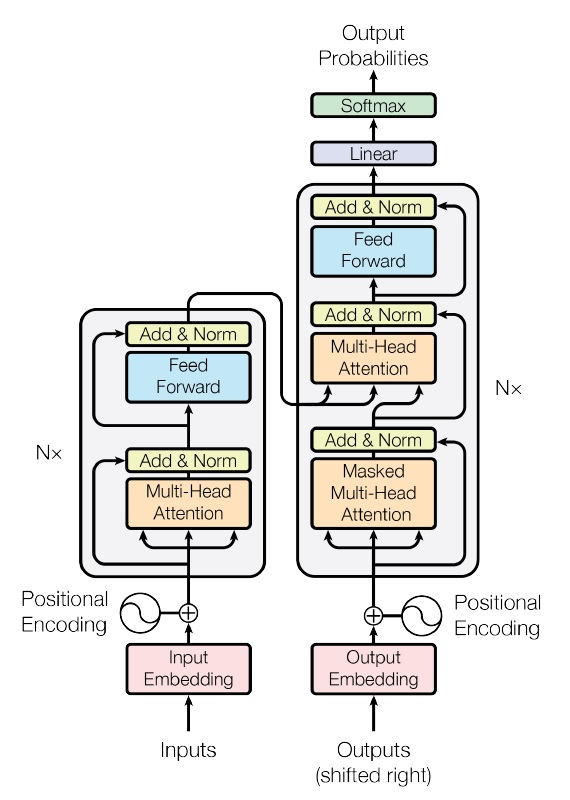


### Team Members:
- Group member 1
    - Name: Alireza Hatami
    - Email: ah3733@drexel.edu
- Group member 2
    - Name: Sai Pokuri
    - Email: sp3867@drexel.edu
- Group member 3
    - Name: Ram Kishore Karuppiah Nadar Venkateswaran
    - Email: rk999@drexel.edu

## Dataset

The project's data comprises the News Summary dataset obtained from Kaggle. This dataset contains a collection of news articles. Each with associated metadata such as author, publication date, headline, URL, a summary of the article (text), and the complete article (ctext).

The task of extractive summarization is formulated within this dataset by selecting and organizing key sentences or spans from the 'ctext' (complete article) to create a summary that captures the main ideas and crucial information. The 'text' column in the dataset represents the manually annotated summaries, which serve as reference summaries for evaluating the performance of the extractive summarization model.

The data would look like this :

| text      | ctext                |
|-----------|----------------------|
| Summary-1 | Summarize: Article 1 |
| Summary-2 | Summarize: Article 2 |
| Summary-3 | Summarize: Article 3 |


In terms of data processing and formulation, the task involves tokenizing the input 'ctext' into tokens or spans and then selecting the most important tokens or spans to construct the output summary. This process is aligned with the concept of extractive summarization, where the summary is generated by extracting and reorganizing existing content from the source text.


The output of the project's task is thus formulated as a sequence of tokens or spans extracted from the input 'ctext,' creating a concise and informative summary that closely matches the content and structure of the reference summaries provided in the 'text' column of the dataset. This approach ensures that the generated summaries are relevant, coherent, and accurately represent the main ideas of the original news articles.

The desired output would be like :

Here's an example based on a hypothetical news article:

**Original Text:**  The government announced new measures to boost the economy, including tax cuts and infrastructure investments. The President emphasized the importance of job creation and economic growth during a press conference yesterday. The new policies aim to stimulate business activity and attract foreign investment.

**Original Summary:**  Government introduces tax cuts and infrastructure investments to boost the economy, with a focus on job creation and attracting foreign investment.

**Generated Summary:**  New government measures include tax cuts and infrastructure investments to spur economic growth and job creation, emphasizing the importance of attracting foreign investment.

In [ ]:
pip install rouge

In [ ]:
import seaborn as sns
import pandas as pd
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import textwrap
from pathlib import Path
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


import seaborn as sns
from tqdm.auto import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from rouge import Rouge
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

In [ ]:
df = pd.read_csv("TextSummarization-Using-Transformers-main/archive 2/news_summary.csv", encoding="latin-1")
df.head()

In [ ]:
headlines_length = [len(x.split()) for x in df.headlines]
text_length = [len(x.split()) for x in df.text]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

In [ ]:
df = df[['text', 'ctext']]
df.head(10)

In [ ]:
df['text'][0]

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, text_max_token_len=512, summary_max_token_len=128):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        text = str(data_row["text"]) if pd.notna(data_row["text"]) else ""
        ctext = str(data_row["ctext"]) if pd.notna(data_row["ctext"]) else ""
        text_encoding = self.tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        summary_encoding = self.tokenizer(
            ctext,
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = summary_encoding['input_ids']
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "text_input_ids": text_encoding["input_ids"].squeeze(),
            "text_attention_mask": text_encoding["attention_mask"].squeeze(),
            "labels": labels.squeeze()
        }

To process the data for text summarization, the data at the given index was retrieved from the DataFrame object. The text was tokenized using the tokenizer object, with the maximum token length set. Similarly, the summary which is **ctext** from the dataset was tokenized using the tokenizer object, with the maximum token length set. The labels for the summary were then set using the *input_ids* tokenization. All 0 values in the labels were replaced with -100 to ignore them during the loss calculation. Finally, a dictionary was returned containing the original text, the summary, the tokenized text input IDs, the attention mask for the text input, the labels for the summary, and the attention mask for the summary input.

In [ ]:
class NewsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 test_df,
                 tokenizer,
                 batch_size=8,
                 text_max_token_len=152,
                 summary_max_token_len=128):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):

        self.train_dataset = NewsDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

        self.test_dataset = NewsDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

    def train_dataloader(self):

        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

    def test_dataloader(self):

        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

    def val_dataloader(self):

        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

The `NewsDataModule` class is for handling news articles data for training and testing. It takes in train and test DataFrames, a tokenizer, and maximum token lengths for both text and summary. The class includes an initialization method to set instance variables, a setup method to create datasets for training, validation, and testing, and methods to return DataLoader objects for each dataset. The setup method specifically creates `NewsDataset` objects with the provided DataFrames and tokenizer, while the DataLoader methods configure batch size and data shuffling.

In [ ]:
MODEL_NAME = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [ ]:
train_df['text'].fillna('', inplace=True)  # Replace NaN with empty strings
train_df['ctext'].fillna('', inplace=True)

# Properly encode the text data, ensuring all inputs are strings and handle truncation
text_token_counts = [
    len(tokenizer.encode(str(row["text"]), max_length=512, truncation=True))
    for _, row in train_df.iterrows()
]
summary_token_counts = [
    len(tokenizer.encode(str(row["ctext"]), max_length=512, truncation=True))
    for _, row in train_df.iterrows()
]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(text_token_counts, ax=ax1, color='blue', alpha=0.7)
ax1.set_title("Distribution of Text Token Counts", fontsize=14, fontweight='bold')
ax1.set_xlabel("Number of Tokens", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.grid(axis='y', alpha=0.5)

sns.histplot(summary_token_counts, ax=ax2, color='green', alpha=0.7)
ax2.set_title("Distribution of Summary Token Counts", fontsize=14, fontweight='bold')
ax2.set_xlabel("Number of Tokens", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.grid(axis='y', alpha=0.5)

plt.suptitle("Token Count Distributions", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
N_EPOCHS = 5
BATCH_SIZE=8

data_module = NewsDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

In [ ]:
class SummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.tokenizer = tokenizer
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

    def shared_step(self, batch, batch_idx, stage):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']

        # Assuming the model does not actually require a labels attention mask
        output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = output.loss
        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [ ]:
model_1 = SummaryModel()

In [ ]:
# Define the checkpoint directory
checkpoint_dir = "checkpoints"

callbacks = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="base-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name="news_summary")

trainer = Trainer(
    logger=logger,
    callbacks=[callbacks],
    max_epochs=N_EPOCHS
)


In [ ]:
trainer.fit(model_1, data_module)

In [ ]:
trained_model = SummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path)

In [ ]:
def summarize(text):
    # Prepare the input text for the model
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Move the tensors to the same device as the model
    text_encoding = {key: val.to(device) for key, val in text_encoding.items()}

    # Generate predictions using the model
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    # Decode the generated ids to text
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return " ".join(preds)


This code defines a function named `summarize` that generates a summary for a given text using a pre-trained T5 Transformer model and tokenizer. The function first prepares the input text by encoding it with specified parameters for maximum length, padding, and truncation, and converts it into PyTorch tensors. These tensors are then moved to the same device as the model (GPU). The function utilizes the model's `generate` method to predict the summary, with parameters set for maximum summary length, number of beams for beam search, repetition penalty, length penalty, and early stopping. Finally, the generated token IDs are decoded back into text format, skipping special tokens and cleaning up spaces, and the resulting summary is returned as a single string. This approach ensures the input text is appropriately processed and summarized using the capabilities of the T5 model.

In [ ]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base').to(device)  # Move the model to the specified device


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
sample_row = test_df.iloc[5]
text = sample_row["text"]
ref_summary = sample_row["ctext"]

model_summary = summarize(text)

print('Original text :  \n', ref_summary)
print('\nPredicted summary :  \n', model_summary)
print('\nOriginal summary :  \n', text)

## Similarity Evaluvation Metrics

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) and BLEU (Bilingual Evaluation Understudy) are used metrics for evaluating the quality of text summaries and machine translations. They serve similar purposes but differ in their methodologies and focus areas. Here is a detailed comparison of these metrics:

### BLEU

It is originally designed for machine translation but often used for summarization. Measures precision of n-grams (contiguous sequences of n tokens) between the generated text and the reference text. But does not consider recall, potentially penalizing good translations that use synonyms or paraphrasing. Sometimes it can be overly strict and not accounting for the flexiblity in language.

### ROUGE

Designed for evaluating text summarization. Focuses on recall, ensuring that most of the important content from the reference is included in the generated summary and includes various versions (ROUGE-N, ROUGE-L, ROUGE-S) to capture different aspects of similarity (n-grams, sentence-level structure, skip-bigrams). It could be more complex and slower to compute compared to BLEU

- **ROUGE-N**: Measures recall of n-grams between the generated summary and the reference summary.
- **ROUGE-L**: Measures the longest common subsequence (LCS) between the generated and reference summaries, capturing sentence-level structure.
- **ROUGE-S**: Measures skip-bigrams, considering pairs of words in their order of appearance but allowing for gaps.

In [ ]:
def compute_metrics(original_summary, predicted_summary):
    # Tokenize summaries for BLEU
    original_tokens = word_tokenize(text)
    predicted_tokens = word_tokenize(model_summary)

    # Compute BLEU score
    bleu_score = sentence_bleu([original_tokens], predicted_tokens)

    # Compute ROUGE scores
    rouge = Rouge()
    scores = rouge.get_scores(predicted_summary, original_summary)[0]

    return {

        'BLEU': bleu_score,
        'ROUGE-N': scores['rouge-1']['f'],
        'ROUGE-S': scores['rouge-2']['f'],
        'ROUGE-L': scores['rouge-l']['f']
    }

compute_metrics(text, model_summary)

ROUGE tends to be the preferred metric for text summarization because it provides a more balanced evaluation by considering both recall and semantic similarity. However, the best choice ultimately depends on the specific requirements and goals of your summarization task. It can also be beneficial to use both metrics in conjunction to get a comprehensive view of the summary quality.

### Project Limitations

throughout the project, we faced some challenges as follows:

1. Before starting the project, we wanted to understand the T5 structure and its detailed explanation in each of its layers. For example, in the case of using T5 base, we wanted to determine how many of the 12 layers use attention and what type of attention layers are utilized. However, we faced some issues finding a valid explanation for the mentioned details. Surprisingly, we could not find any elaborate documentation on the Google website, except for some general information about the model. The reason is understandable because they want to keep the details of their architectures confidential. However, having knowledge of these details can be extremely beneficial for graduate students who are just starting, as it allows us to analyze the code before implementing it. We had to utilize different available resources and refer to the article introducing T5 by Raffel et al. (2020), "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer". The article was quite technical and required extensive knowledge to understand all its details, which takes a substantial amount of time. We had to utilize our limited knowledge of transformer models from Vaswani et al. (2017) and understand the attention mechanism. From there, we speculated that T5 probably functions in a very similar way with some minor adjustments
.
2. The next limitation was that we thought the process would be easier since it is a pre-trained model, and we could achieve a good result with the summarization task. However, we were not aware of the trade-off; getting high-quality summarization comes with a lot of complex implementation. On the other hand, the class on attention layers and transformers for summarization was scheduled last throughout the quarter. We found that creating an encoder-decoder transformer based on the course materials from the previous session is much easier than implementing something that requires a lot of adjustments with limited documentation available. However, designing our own transformer would likely lead to lower-quality summarization, so it's a trade-of
f.
3. Our limited computational power and time were additional constraints we faced. Even with Google Colab, we still had to reduce the number of epochs to ensure the timely completion of the projeWe wanted to implement T5 and then compare its performance with other models, if possible. However, we did not realize that each of these pre-trained models would take a long time to implement correctly. ct. This course provided essential foundational concepts, but we feel that condensing it into a two-month quarter on a fast-paced system sacrifices important learning opportunities and reduces our focus on what truly matters. To us, this course was really important and mattered a lot. Unfortunately, we feel that it didn't go the way we wanted, even though we really tried our best.


### Recommendation and Future Study

Here are some recommendations that come to mind:

1. More studies are needed to explore the different nuances of pre-trained models like T5. As mentioned earlier, T5 has different types, which need comprehensive documentation. So far, the original article, Hugging Face, and some fragmented and unvalidated sources are available about the implementation of these pre-trained models.
2. Since we have multiple types, each with a different number of layers and parameters, we must compare the performance of different T5 models. For instance, the same summarization task must be done by implementing various types of T5 and explaining the results. The outcome of such a comparison would help us choose which type of T5 model we can effectively select for our needed task.
3. More studies similar to Muia et al. (2024) are needed to compare the performance of T5 with other models such as PEGASUS, BERT, or GPT, etc.
4. The final recommendation must be included in the course evaluation, but we need to address the important issue that this course requires a prerequisite course teaching foundational concepts in more detail. Currently, none of the core courses at Drexel provides this. By having suitable prerequisites, we can focus more on important topics such as exploring and analyzing transformers, which are fundamental to LLMs. LLMs are essential for data scientists, so this course should be a core course in the future, not an elective.

**Reference:**

Google Cloud Tech. (2023, June 5). Attention mechanism: Overview [Video]. https://www.youtube.com/watch?v=fjJOgb-E41w

Hugging Face, https://huggingface.co/docs/transformers/en/model_doc/t5

Muia, C. M., Oirere, A. M., & Ndungu, R. N. (2024). A Comparative Study of Transformer-based Models for Text Summarization of News Articles.

Raffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., ... & Liu, P. J. (2020). Exploring the limits of transfer learning with a unified text-to-text transformer. Journal of machine learning research, 21(140), 1-67es.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systemseWikipedia, l_doc/t5

https://en.wikipedia.org/wiki/T5_(language_model)#:~:text=T5%20(Text%2Dto%2DText,text%2Dto%2Dtext%20framework.